In [3]:
!pip install tensorflow


  Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl.metadata (3.3 kB)
  Using cached tensorflow_intel-2.18.0-cp312-cp312-win_amd64.whl.metadata (4.9 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached ml_dtypes-0.4.1-cp312-cp312-win_amd64.whl.metadata (20 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB

In [9]:
!pip install scipy

In [11]:
#Libraries needed
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import numpy as np
import pandas as pd
import SimpleITK as sitk
from matplotlib import pyplot as plt
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from scipy import ndimage
import math
from skimage.filters import threshold_mean
import cv2

C:\Users\clarynse\AppData\Local\Temp\ipykernel_20452\3513155087.py:8: DeprecationWarning: Please import `map_coordinates` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import map_coordinates
C:\Users\clarynse\AppData\Local\Temp\ipykernel_20452\3513155087.py:9: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


In [19]:
#Reading Nifti Image
#Using SimpleITK for most tasks
# Reading- Image

ct_path='NasalSeg/nnUNet_raw/Dataset123_NasalSeg/imagesTr/P001_0000.nii.gz'
ct_label_path='NasalSeg/nnUNet_raw/Dataset123_NasalSeg/labelsTr/P001.nii.gz'

# CT
img_sitk  = sitk.ReadImage(ct_path, sitk.sitkFloat32) # Reading CT
image     = sitk.GetArrayFromImage(img_sitk) #Converting sitk_metadata to image Array
# Mask
mask_sitk = sitk.ReadImage(ct_label_path,sitk.sitkInt32) # Reading CT
mask      = sitk.GetArrayFromImage(mask_sitk)#Converting sitk_metadata to image Array

print('CT Shape={}'.format(image.shape))
print('CT Mask Shape={}'.format(mask.shape))



CT Shape=(52, 205, 153)
CT Mask Shape=(52, 205, 153)


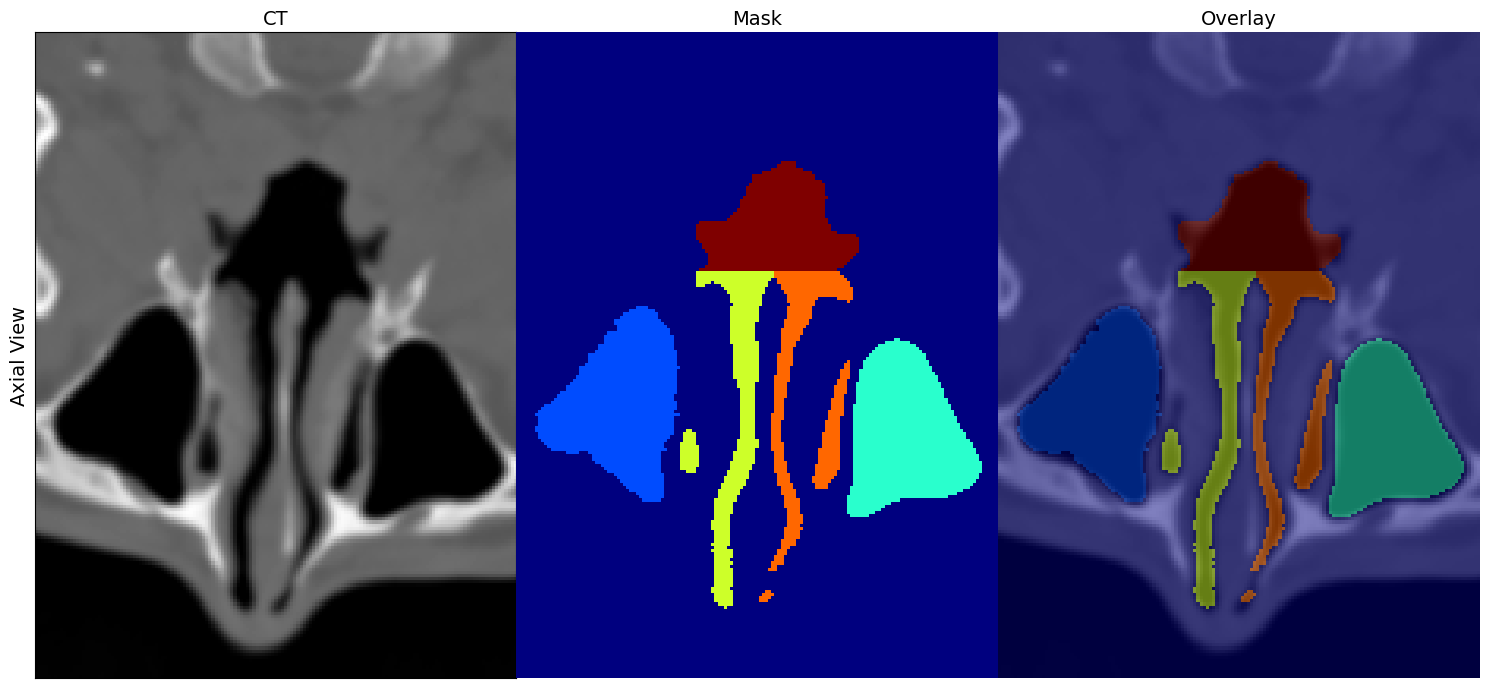

In [23]:
f, axarr = plt.subplots(1, 3, figsize=(15, 15))
slice_idx = image.shape[0] // 2  # Pick middle slice

axarr[0].imshow(np.squeeze(image[slice_idx, :, :]), cmap='gray', origin='lower')
axarr[0].set_ylabel('Axial View', fontsize=14)
axarr[0].set_xticks([])
axarr[0].set_yticks([])
axarr[0].set_title('CT', fontsize=14)

axarr[1].imshow(np.squeeze(mask[slice_idx, :, :]), cmap='jet', origin='lower')
axarr[1].axis('off')
axarr[1].set_title('Mask', fontsize=14)

axarr[2].imshow(np.squeeze(image[slice_idx, :, :]), cmap='gray', alpha=1, origin='lower')
axarr[2].imshow(np.squeeze(mask[slice_idx, :, :]), cmap='jet', alpha=0.5, origin='lower')
axarr[2].axis('off')
axarr[2].set_title('Overlay', fontsize=14)

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)


In [25]:
#Intensity Normalization
def normalise(image):
    # normalise and clip images -1000 to 800
    np_img = image
    np_img = np.clip(np_img, -1000., 800.).astype(np.float32)
    return np_img


def whitening(image):
    """Whitening. Normalises image to zero mean and unit variance."""

    image = image.astype(np.float32)

    mean = np.mean(image)
    std = np.std(image)

    if std > 0:
        ret = (image - mean) / std
    else:
        ret = image * 0.
    return ret


def normalise_zero_one(image):
    """Image normalisation. Normalises image to fit [0, 1] range."""

    image = image.astype(np.float32)

    minimum = np.min(image)
    maximum = np.max(image)

    if maximum > minimum:
        ret = (image - minimum) / (maximum - minimum)
    else:
        ret = image * 0.
    return ret


def normalise_one_one(image):
    """Image normalisation. Normalises image to fit [-1, 1] range."""

    ret = normalise_zero_one(image)
    ret *= 2.
    ret -= 1.
    return ret



Normalize_minun100_to_800hu=normalise(image)
Normalize_0mean_UnitVr=whitening(image)
Normalize_0to1=normalise_zero_one(image)
normalise_minus1_to1=normalise_one_one(image)

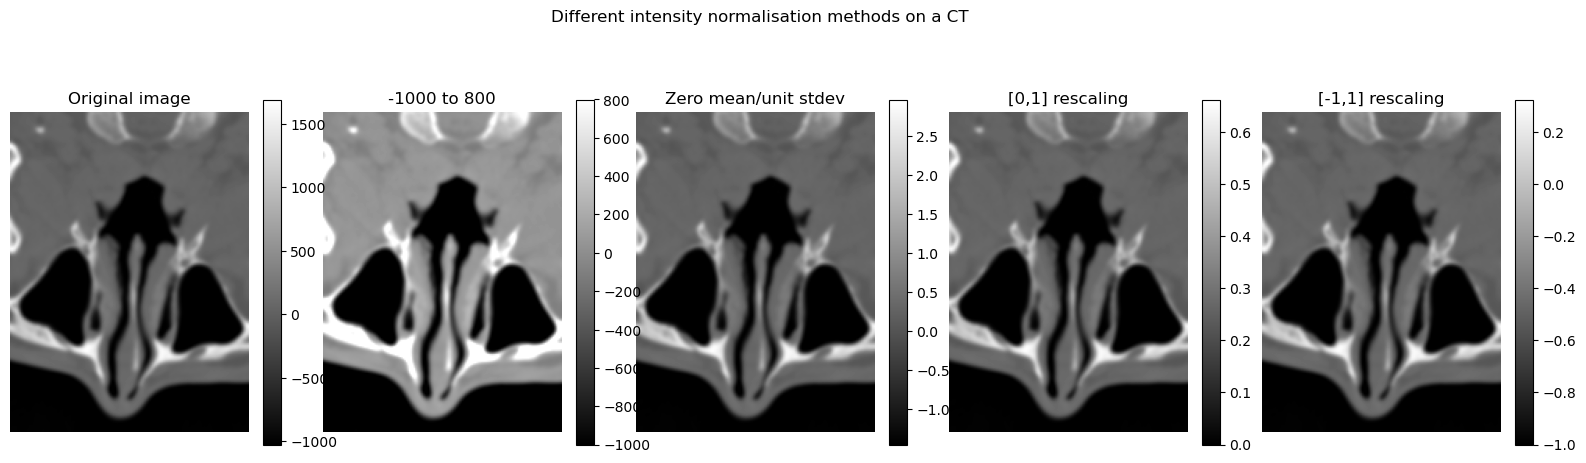

In [31]:
#Different normalization methods on CT 

f, axarr = plt.subplots(1, 5, figsize=(20,5));
f.suptitle('Different intensity normalisation methods on a CT')

img = axarr[0].imshow(np.squeeze(image[slice_idx, :, :]), cmap='gray',origin='lower');
axarr[0].axis('off')
axarr[0].set_title('Original image')
f.colorbar(img, ax=axarr[0])

img = axarr[1].imshow(np.squeeze(Normalize_minun100_to_800hu[slice_idx, :, :]), cmap='gray',origin='lower');
axarr[1].axis('off')
axarr[1].set_title('-1000 to 800')
f.colorbar(img, ax=axarr[1])

img = axarr[2].imshow(np.squeeze(Normalize_0mean_UnitVr[slice_idx, :, :]), cmap='gray',origin='lower');
axarr[2].axis('off')
axarr[2].set_title('Zero mean/unit stdev')
f.colorbar(img, ax=axarr[2])

img = axarr[3].imshow(np.squeeze(Normalize_0to1[slice_idx, :, :]), cmap='gray',origin='lower');
axarr[3].axis('off')
axarr[3].set_title('[0,1] rescaling')
f.colorbar(img, ax=axarr[3])

img = axarr[4].imshow(np.squeeze(normalise_minus1_to1[slice_idx, :, :]), cmap='gray',origin='lower');
axarr[4].axis('off')
axarr[4].set_title('[-1,1] rescaling')
f.colorbar(img, ax=axarr[4])
    
f.subplots_adjust(wspace=0.05, hspace=0, top=0.8)
plt.show();

In [35]:
#Resampling
def resample_img(itk_image, out_spacing=[2.0, 2.0, 2.0], is_label=False):
    # resample images to 2mm spacing with simple itk

    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image)


ct_resampled_to1m=resample_img(img_sitk, out_spacing=[1, 1, 1], is_label=False)
ct_resampled_to1m=sitk.GetArrayFromImage(ct_resampled_to1m)
mask_resampled_to1m=resample_img(mask_sitk, out_spacing=[1, 1, 1], is_label=True)
mask_resampled_to1m=sitk.GetArrayFromImage(mask_resampled_to1m)
print('CT Shape Original={}, Resampled to 1mm={}'.format(image.shape,ct_resampled_to1m.shape))
print('CT Mask Shape={}, Resampled to 1mm={}'.format(mask.shape,mask_resampled_to1m.shape))



CT Shape Original=(52, 205, 153), Resampled to 1mm=(52, 205, 153)
CT Mask Shape=(52, 205, 153), Resampled to 1mm=(52, 205, 153)


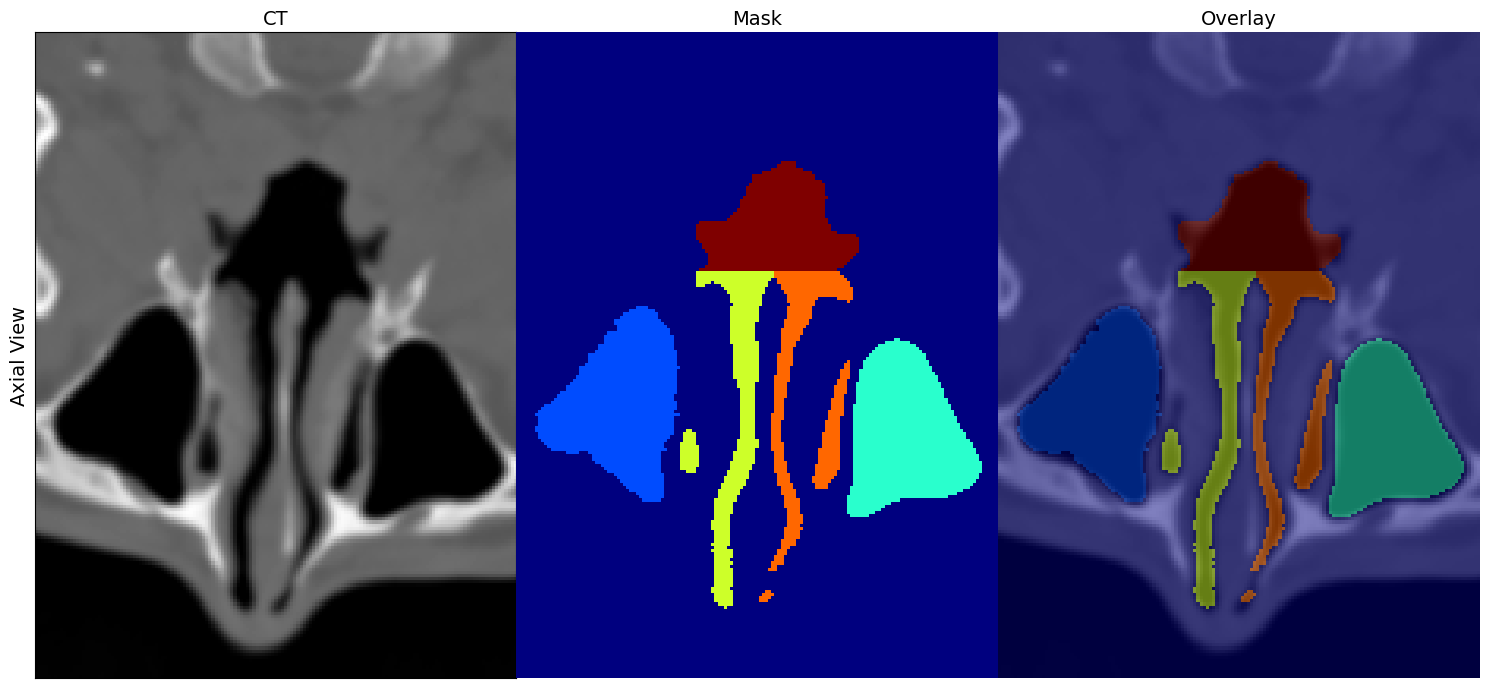

In [37]:
#Plotting 
f, axarr = plt.subplots(1,3,figsize=(15,15))
axarr[0].imshow(np.squeeze(ct_resampled_to1m[slice_idx, :, :]), cmap='gray',origin='lower');
axarr[0].set_ylabel('Axial View',fontsize=14)
axarr[0].set_xticks([])
axarr[0].set_yticks([])
axarr[0].set_title('CT',fontsize=14)

axarr[1].imshow(np.squeeze(mask_resampled_to1m[slice_idx, :, :]), cmap='jet',origin='lower');
axarr[1].axis('off')
axarr[1].set_title('Mask',fontsize=14)

axarr[2].imshow(np.squeeze(ct_resampled_to1m[slice_idx, :, :]), cmap='gray',alpha=1,origin='lower');
axarr[2].imshow(np.squeeze(mask_resampled_to1m[slice_idx, :, :]),cmap='jet',alpha=0.5,origin='lower');
axarr[2].axis('off')
axarr[2].set_title('Overlay',fontsize=14)
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

In [57]:
#Crop or padding
import numpy as np

def resize_image_with_crop_or_pad(image, img_size=(64, 64, 64), **kwargs):
    """Resizes image by cropping or padding dimensions to fit specified size.
    
    Args:
        image (np.ndarray): Input image to be resized.
        img_size (tuple or list): Target image size (Depth, Height, Width).
        kwargs: Additional arguments for np.pad.
    
    Returns:
        np.ndarray: Resized image.
    """

    assert isinstance(image, np.ndarray), "Input must be a numpy array."
    assert (image.ndim == len(img_size)), "Mismatch between image dimensions and target size."

    # Number of dimensions
    rank = len(img_size)

    # Define cropping indices and padding sizes
    from_indices = [[0, min(image.shape[dim], img_size[dim])] for dim in range(rank)]
    to_padding = [[0, 0] for dim in range(rank)]

    slicer = [slice(None)] * rank  # Default slicer (no cropping initially)

    for i in range(rank):
        if image.shape[i] < img_size[i]:  # Padding needed
            to_padding[i][0] = max(0, (img_size[i] - image.shape[i]) // 2)
            to_padding[i][1] = max(0, img_size[i] - image.shape[i] - to_padding[i][0])
        else:  # Cropping needed
            from_indices[i][0] = max(0, (image.shape[i] - img_size[i]) // 2)
            from_indices[i][1] = from_indices[i][0] + img_size[i]

        slicer[i] = slice(from_indices[i][0], from_indices[i][1])

    # Perform cropping
    cropped_image = image[tuple(slicer)]

    # Perform padding if needed
    if any(any(pad > 0 for pad in pad_pair) for pad_pair in to_padding):
        cropped_image = np.pad(cropped_image, to_padding, **kwargs)

    return cropped_image

# Example usage:
# Ensure `image` is a valid numpy array before calling
# Cropping example: Resize image to [128, 128, 128]
img_cropped = resize_image_with_crop_or_pad(image, [128, 128, 128], mode='symmetric')

# Padding example: Resize image to [256, 256, 256]
img_padded = resize_image_with_crop_or_pad(image, [256, 256, 256], mode='symmetric')


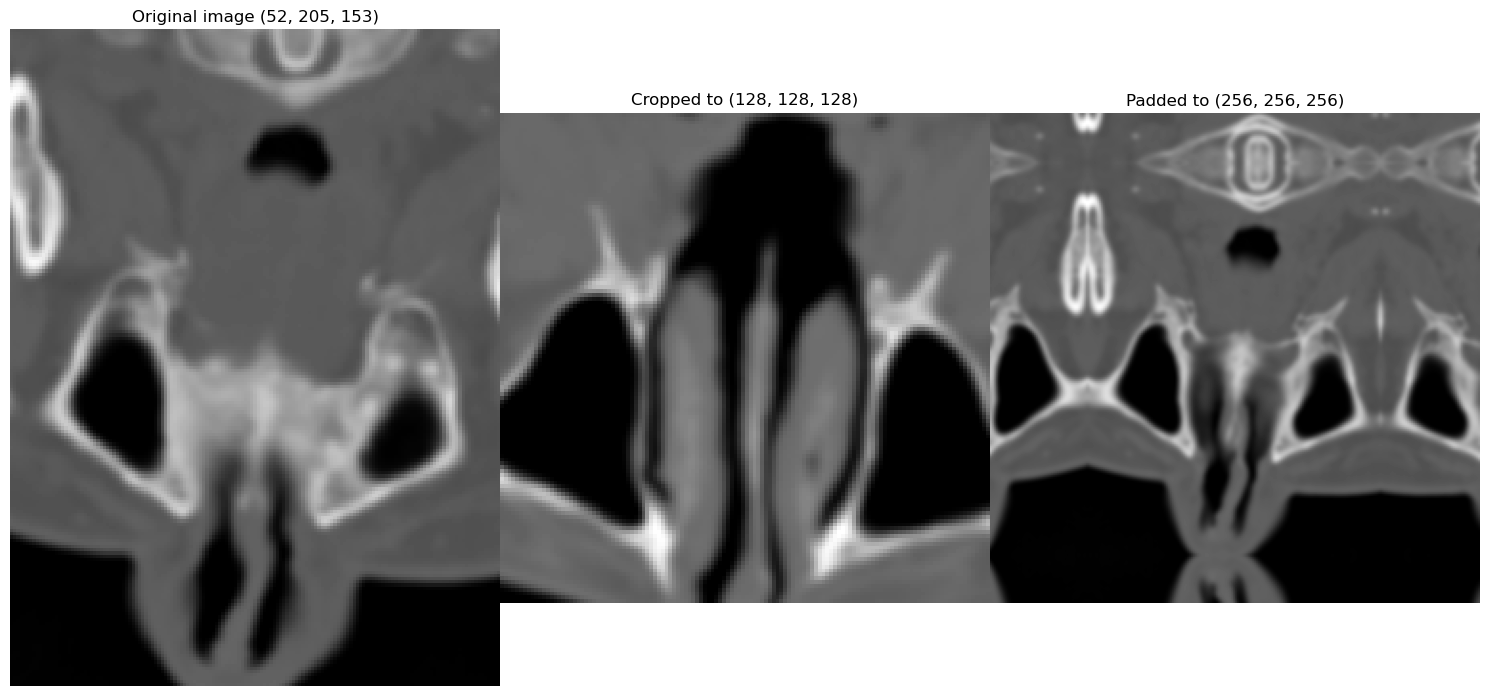

In [59]:
# Visualise using matplotlib.
f, axarr = plt.subplots(1, 3, figsize=(15,15));
axarr[0].imshow(np.squeeze(image[15, :, :]), cmap='gray',origin='lower');
axarr[0].axis('off')
axarr[0].set_title('Original image {}'.format(image.shape))

axarr[1].imshow(np.squeeze(img_cropped[15, :, :]), cmap='gray',origin='lower');
axarr[1].axis('off')
axarr[1].set_title('Cropped to {}'.format(img_cropped.shape))

axarr[2].imshow(np.squeeze(img_padded[15, :, :]), cmap='gray',origin='lower');
axarr[2].axis('off')
axarr[2].set_title('Padded to {}'.format(img_padded.shape))
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

In [61]:
#Histogram Matching
def histogram_matching(mov_scan, ref_scan,
                       histogram_levels=2048,
                       match_points=100,
                       set_th_mean=True):
    """
    Histogram matching following the method developed on
    Nyul et al 2001 (ITK implementation)
    inputs:
    - mov_scan: np.array containing the image to normalize
    - ref_scan np.array containing the reference image
    - histogram levels
    - number of matched points
    - Threshold Mean setting
    outputs:
    - histogram matched image
    """

    # convert np arrays into itk image objects
    ref = sitk.GetImageFromArray(ref_scan.astype('float32'))
    mov = sitk.GetImageFromArray(mov_scan.astype('float32'))

    # perform histogram matching
    caster = sitk.CastImageFilter()
    caster.SetOutputPixelType(ref.GetPixelID())

    matcher = sitk.HistogramMatchingImageFilter()
    matcher.SetNumberOfHistogramLevels(histogram_levels)
    matcher.SetNumberOfMatchPoints(match_points)
    matcher.SetThresholdAtMeanIntensity(set_th_mean)
    matched_vol = matcher.Execute(mov, ref)

    return matched_vol

In [63]:
#Maximum Intensity Projection
import SimpleITK as sitk
import os
from os import listdir
from os.path import isfile, join
import glob
import numpy as np

'''
This function was deigned to Give MIP for two label Left and Right Lung.
if you have your own labels change or introduce for label indexes based on your need. 
Otherwise if you don't have labels set give_onlysegmented_data=False ony want to MIP between slices indicate the within how many slices it should count.
'''

def MIP_onrun(img,lbl,slices_num,give_onlysegmented_data=True):

    """ Performed maximum instensity projection.

    Args:
        image (np.ndarray): image to perform mip
        label (np.ndarray): labels to use for extraxting classes the classes
        slices_num(int):

    Returns:
        Returned maximum intensity projected ndarray.
        give_onlysegmented_data=True, returns only the segmented Regions.

    """
    img_flatten=img.flatten()
    lbl_flatten=lbl.flatten()
    img_new=img.flatten()

    ###Getting the Index for Right and Left Lung

    idx_rl = np.argwhere(lbl_flatten == 2.0)
    idx_ll = np.argwhere(lbl_flatten == 3.0)

    #print(len(idx_rl))
    #print(len(idx_ll))

    idx_Index_1=np.argwhere(lbl_flatten<2)
    #print(len(idx_Index_1))
    idx_3up=np.argwhere(lbl_flatten>3)
    #print(len(idx_3up))

    ###########Removing all other labels
    img_new[idx_Index_1]=0.0
    img_new[idx_3up]=0.0

    img_new_reshape=np.reshape(img_new,img.shape)


    def createMIP(np_img, slices_num):
        ''' create the mip image from original image, slice_num is the number of
        slices for maximum intensity projection'''
        img_shape = np_img.shape
        np_mip = np.zeros(img_shape)
        for i in range(img_shape[0]):
            start = max(0, i-slices_num)
            np_mip[i,:,:] = np.amax(np_img[start:i+1],0)
        return np_mip

    np_mip = createMIP(img_new_reshape,slices_num=slices_num)

    if give_onlysegmented_data is True:

       final_img=np_mip
    else:

        np_mip_flatten=np_mip.flatten()
        np_mip_flatten[idx_Index_1]=img_flatten[idx_Index_1]
        np_mip_flatten[idx_3up]=img_flatten[idx_3up]

        final_img=np.reshape(np_mip_flatten,np_mip.shape)

    return final_img